In [48]:
#For colab
"""
!pip install \
'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q roboflow supervision
!wget -q \
'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'
#'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth'
"""

"\n!pip install 'git+https://github.com/facebookresearch/segment-anything.git'\n!pip install -q roboflow supervision\n!wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'\n#'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth'\n"

In [49]:
import torch
from segment_anything import SamPredictor, sam_model_registry

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_b"

sam = sam_model_registry[MODEL_TYPE](checkpoint="./models/medsam_vit_b.pth")
#sam = sam_model_registry[MODEL_TYPE](checkpoint="./models/sam_vit_b_01ec64.pth")

sam.to(DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


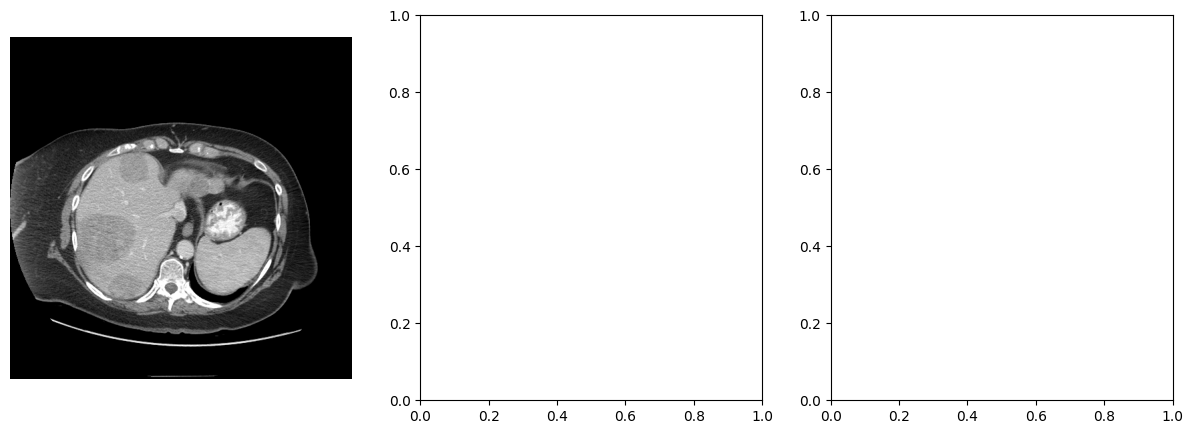

In [50]:
from PIL import Image
import os
import cv2
from matplotlib import pyplot as plt

"""
dir_path = "./data/images/256/"

images = []
images_names = []
for file in os.listdir(dir_path):
    if file.endswith(".png"):
        images_names.append(str(file))
        image_bgr = cv2.imread(os.path.join(dir_path, file))
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        images.append(image_rgb)

images = images[:10]
images_names = images_names[:10]
"""
images = [cv2.imread("./MedSAM/assets/img_demo.png")]
images_names = ["img_demo.png"]

import random
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(1):
    axs[i].imshow(np.array(images[random.randint(0, len(images))]))
    axs[i].axis("off")

In [51]:
def draw_masks_fromDict(image, masks_generated) :
  masked_image = image.copy()
  for i in range(len(masks_generated)) :
    masked_image = np.where(np.repeat(masks_generated[i]['segmentation'].astype(int)[:, :, np.newaxis], 3, axis=2),
                            np.random.choice(range(256), size=3),
                            masked_image)

    masked_image = masked_image.astype(np.uint8)

  return cv2.addWeighted(image, 0.3, masked_image, 0.7, 0)

In [52]:
def preprocessing(image):
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]]) 
    img = cv2.filter2D(image, -1, kernel)
    img = cv2.convertScaleAbs(img, alpha=1.35, beta=10)
    return img

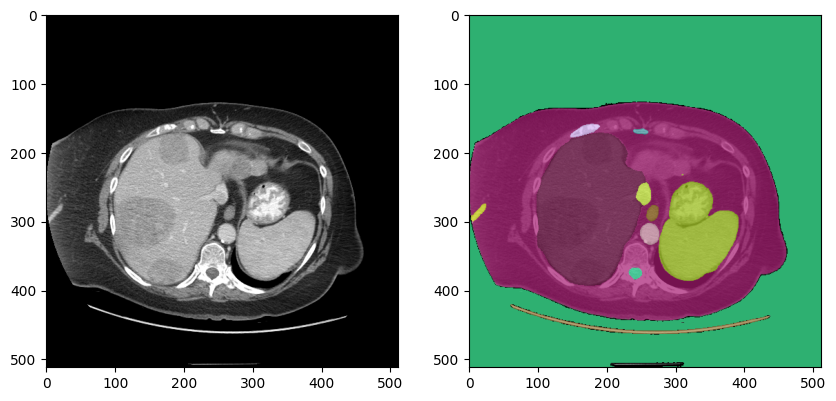

In [53]:
from segment_anything import SamAutomaticMaskGenerator

mask_generator = SamAutomaticMaskGenerator(sam)

if len(images) == 1:
  fig, axis = plt.subplots(1,2,figsize=(10,60))
  input = preprocessing(images[0])
  masks = mask_generator.generate(input)
  segmented_image = draw_masks_fromDict(images[0], masks)
  axis[0].imshow(images[0])
  axis[1].imshow(segmented_image, cmap='gray')

else:
  fig, axis = plt.subplots(len(images),2,figsize=(10,60))
  all_masks = []
  for i,img in enumerate(images):
    axis[i][0].imshow(img)
    input = preprocessing(img)
    masks = mask_generator.generate(input)
    all_masks.append(masks)
    segmented_image = draw_masks_fromDict(img, masks)
    axis[i][1].imshow(segmented_image, cmap='gray')

In [54]:
#Save each part of the image corresponding to the mask
"""
for i in range(len(images)):
    for j in range(len(all_masks[i])):
        bbox = all_masks[i][j]['bbox']
        x, y, w, h = bbox
        x = int(x)
        y = int(y)
        w = int(w)
        h = int(h)
        roi = images[i][y:y+h, x:x+w]
        if roi.size != 0:
            cv2.imwrite("image_{}_mask_{}.png".format(images_names[i], j), cv2.cvtColor(roi, cv2.COLOR_RGB2BGR))
"""

'\nfor i in range(len(images)):\n    for j in range(len(all_masks[i])):\n        bbox = all_masks[i][j][\'bbox\']\n        x, y, w, h = bbox\n        x = int(x)\n        y = int(y)\n        w = int(w)\n        h = int(h)\n        roi = images[i][y:y+h, x:x+w]\n        if roi.size != 0:\n            cv2.imwrite("image_{}_mask_{}.png".format(images_names[i], j), cv2.cvtColor(roi, cv2.COLOR_RGB2BGR))\n'